In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

import numpy as np                    # Linear Algebra

import matplotlib.pyplot as plt       # Visualizations
import seaborn as sns                 # Visualizations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 
import warnings                       # Hide warning messages
warnings.filterwarnings("ignore")
%matplotlib inline      

In [ ]:
chunk_size = 2000000 
batch_no = 1

In [ ]:
#df1 = pd.read_csv('/content/gdrive/My Drive/fyp/train_small.csv', nrows=1000000)
df1 = pd.read_csv('/content/gdrive/My Drive/FYP dataset/train_small.csv')
df1.shape
df1.head()


,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
0,IDsrk7SoW,2017-01-14 09:42:09,4709696.0,887235,17714,20301556,e,Firefox,NaN,0
1,IDmMSxHur,2017-01-18 17:50:53,5189467.0,178235,21407,9434818,b,Mozilla Firefox,Desktop,0
2,IDVLNN0Ut,2017-01-11 12:46:49,98480.0,518539,25085,2050923,a,Edge,NaN,0
3,ID32T6wwQ,2017-01-17 10:18:43,8896401.0,390352,40339,72089744,c,Firefox,Mobile,0
4,IDqUShzMg,2017-01-14 16:02:33,5635120.0,472937,12052,39507200,d,Mozilla Firefox,Desktop,0


In [ ]:
enc = OrdinalEncoder()
df2 = df1
df2 = df2[pd.notnull(df2['devid'])]
df2 = df2[pd.notnull(df2['countrycode'])]
df2 = df2[pd.notnull(df2['browserid'])]

In [ ]:
df2[['countrycode' , 'devid' , 'browserid']] = enc.fit_transform(df2[['countrycode' , 'devid' , 'browserid']])

In [ ]:
df2.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
1,IDmMSxHur,2017-01-18 17:50:53,5189467.0,178235,21407,9434818,1.0,8.0,0.0,0
3,ID32T6wwQ,2017-01-17 10:18:43,8896401.0,390352,40339,72089744,2.0,2.0,1.0,0
4,IDqUShzMg,2017-01-14 16:02:33,5635120.0,472937,12052,39507200,3.0,8.0,0.0,0
5,IDjO9XQ1Z,2017-01-14 12:08:49,2729292.0,961176,33638,47079934,4.0,3.0,1.0,0
7,IDFnmhUgG,2017-01-13 05:58:13,7295565.0,144797,33638,23981625,1.0,2.0,1.0,0


In [ ]:
df2.shape


(9800581, 10)

In [ ]:
df2.columns
df2.isnull().sum() # Number of missing values in each column
## site id has way too many NaN entries for now I am dropping it  
df2 = df2.drop(['siteid'], axis=1) # deleting timestamp

In [ ]:
df2.columns

Index(['ID', 'datetime', 'offerid', 'category', 'merchant', 'countrycode',
       'browserid', 'devid', 'click'],
      dtype='object')

In [ ]:
df2['datetime'] = pd.to_datetime(df2['datetime']) 
# Converting datetime column into datatime object in order to extract new features
df2['Month'] = df2['datetime'].dt.month 
# Creates a new column called Month
df2['Day'] = df2['datetime'].dt.day     
# Creates a new column called Day
df2['Hour'] = df2['datetime'].dt.hour   
# Creates a new column called Hour
df2["Weekday"] = df2['datetime'].dt.dayofweek 
# Creates a new column called Weekday with sunday as 6 and monday as 0
# Other way to create a weekday column
#df2['weekday'] = df2['datetime'].apply(lambda x: x.weekday()) # Monday 0 .. sunday 6
# Dropping datetime column to avoid redundancy
df2 = df2.drop(['datetime'], axis=1) # deleting datetime

In [ ]:
df2 = df2.drop(['ID'], axis=1) # deleting timestamp

In [ ]:
df2.head()


,offerid,category,merchant,countrycode,browserid,devid,click,Month,Day,Hour,Weekday
1,178235,21407,9434818,1.0,8.0,0.0,0,1,18,17,2
3,390352,40339,72089744,2.0,2.0,1.0,0,1,17,10,1
4,472937,12052,39507200,3.0,8.0,0.0,0,1,14,16,5
5,961176,33638,47079934,4.0,3.0,1.0,0,1,14,12,5
7,144797,33638,23981625,1.0,2.0,1.0,0,1,13,5,4


In [ ]:
numerical_cols = ['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
        'Month', 'Day', 'Hour', 'Weekday']

In [ ]:
df2.shape

(9800581, 11)

In [ ]:
df2[numerical_cols].describe()


,offerid,category,merchant,countrycode,browserid,devid,Month,Day,Hour,Weekday
count,9.800581e+06,9.800581e+06,9.800581e+06,9.800581e+06,9.800581e+06,9.800581e+06,9800581.0,9.800581e+06,9.800581e+06,9.800581e+06
mean,4.966449e+05,4.215372e+04,4.901230e+07,1.628992e+00,3.239461e+00,1.050787e+00,1.0,1.491189e+01,1.261058e+01,2.862916e+00
std,2.897511e+05,2.950272e+04,2.916877e+07,1.613655e+00,2.642376e+00,7.786713e-01,0.0,3.088081e+00,3.885184e+00,1.732894e+00
min,0.000000e+00,9.700000e+01,2.604430e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000e+01,0.000000e+00,0.000000e+00
25%,2.475210e+05,1.496000e+04,2.639177e+07,1.000000e+00,1.000000e+00,0.000000e+00,1.0,1.200000e+01,1.000000e+01,1.000000e+00
50%,4.957550e+05,4.033900e+04,4.861553e+07,1.000000e+00,2.000000e+00,1.000000e+00,1.0,1.500000e+01,1.300000e+01,3.000000e+00
75%,7.472630e+05,6.678600e+04,7.436361e+07,3.000000e+00,6.000000e+00,2.000000e+00,1.0,1.700000e+01,1.600000e+01,4.000000e+00
max,9.999980e+05,9.991400e+04,9.977043e+07,5.000000e+00,1.000000e+01,2.000000e+00,1.0,2.000000e+01,2.300000e+01,6.000000e+00


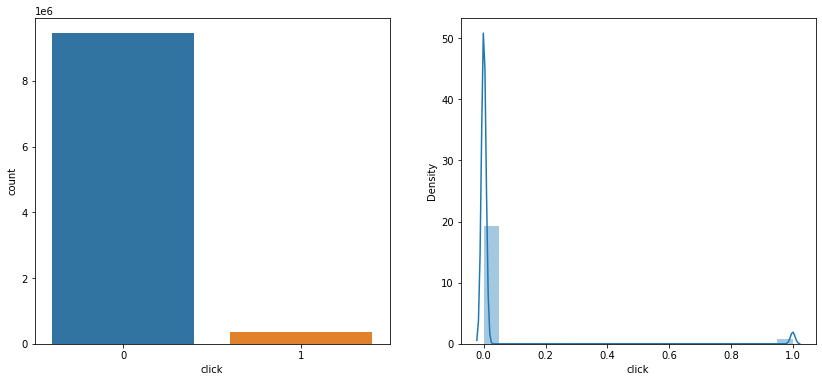

In [ ]:
# Visualizing target variable Clicked on Ad
plt.figure(figsize = (14, 6)) 
plt.subplot(1,2,1)            
sns.countplot(x = 'click', data = df2)
plt.subplot(1,2,2)
sns.distplot(df2["click"], bins = 20)
plt.show()

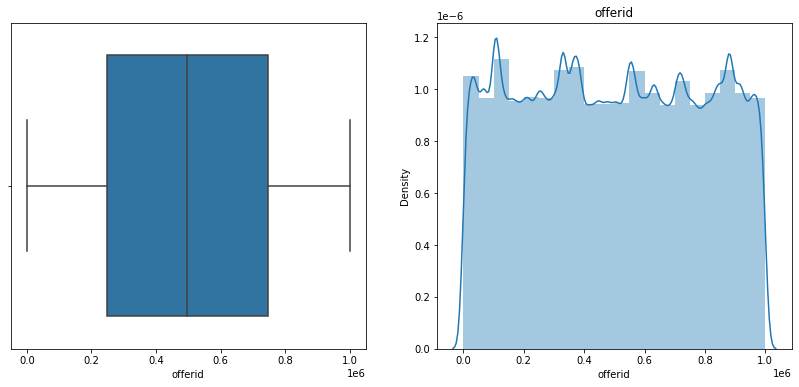

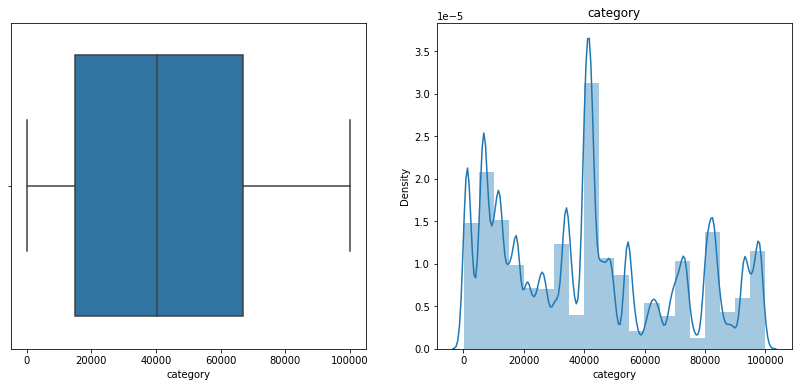

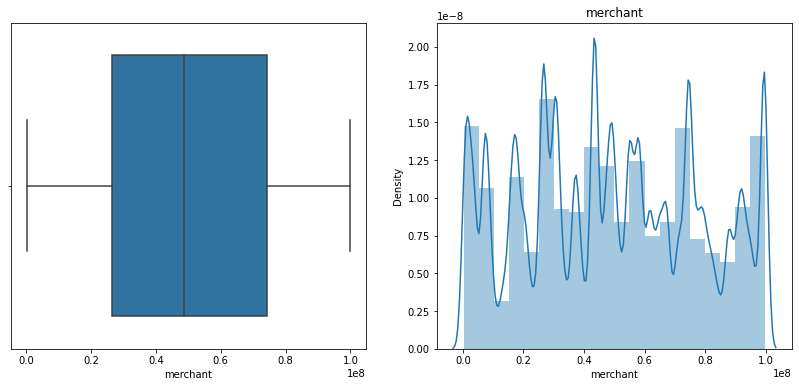

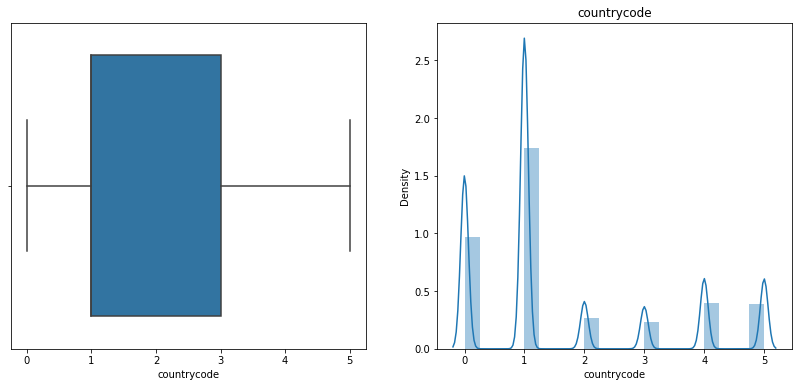

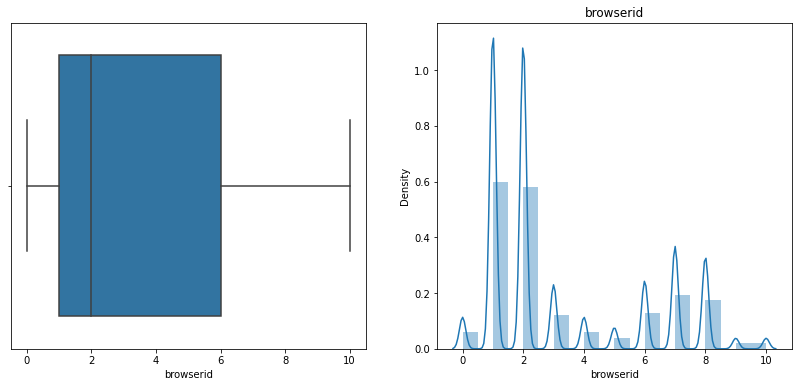

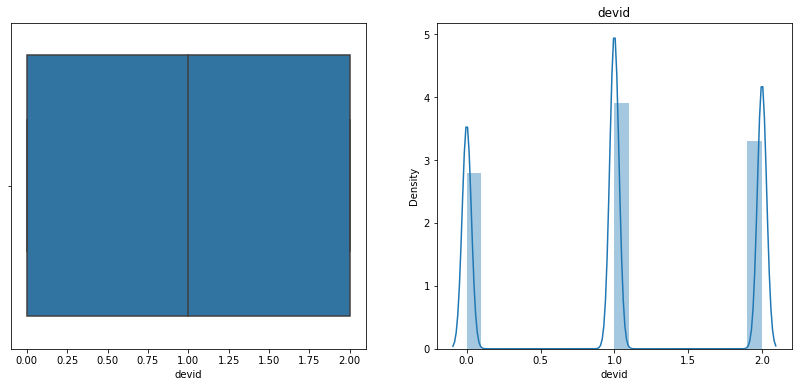

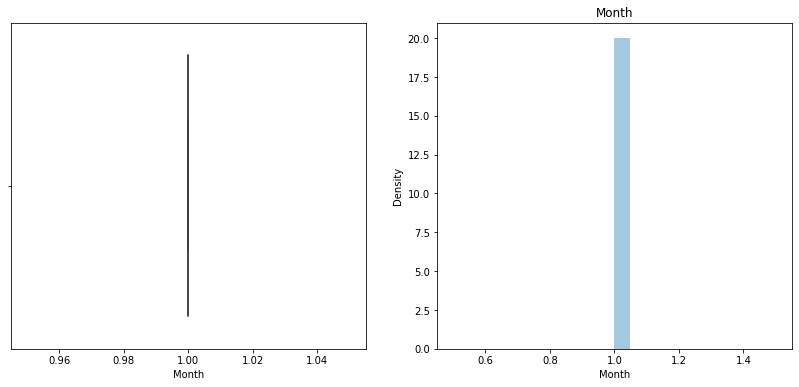

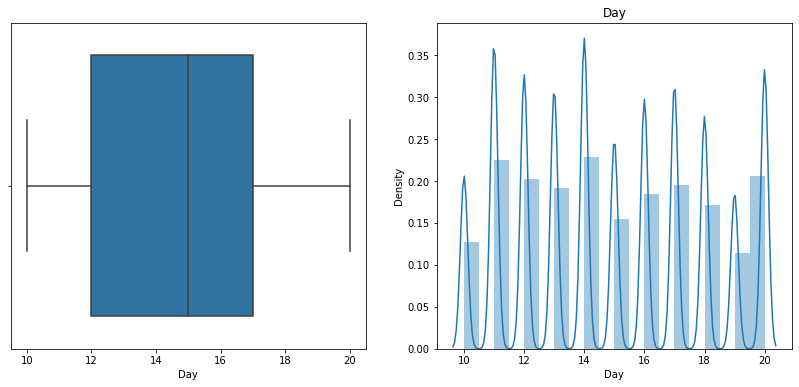

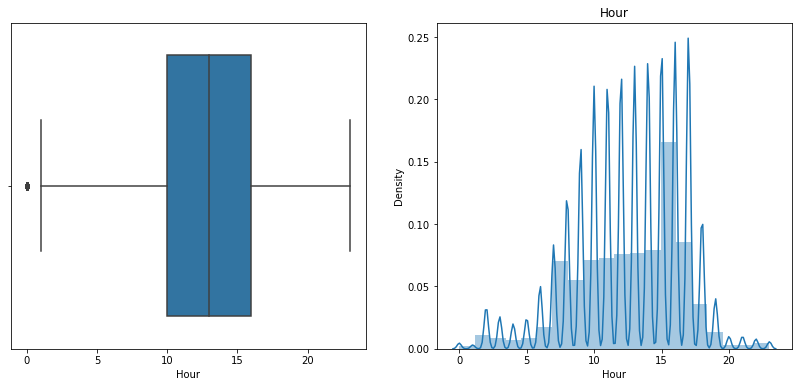

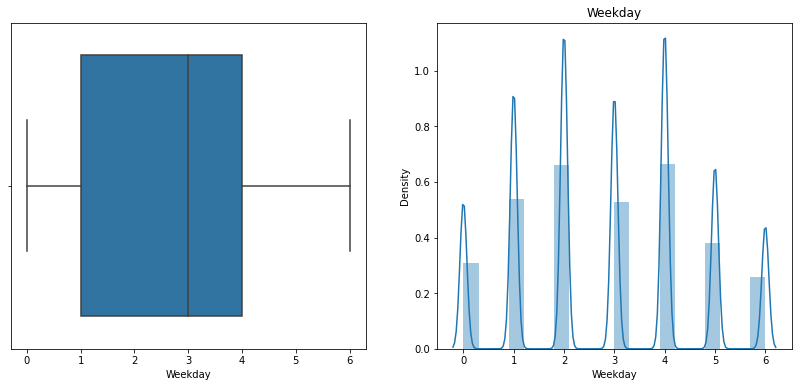

In [ ]:
plots =  ['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
        'Month', 'Day', 'Hour', 'Weekday']

for i in plots:
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(df2[i])
    plt.subplot(1,2,2)
    sns.distplot(df2[i],bins= 20)    
    plt.title(i)    
    plt.show()

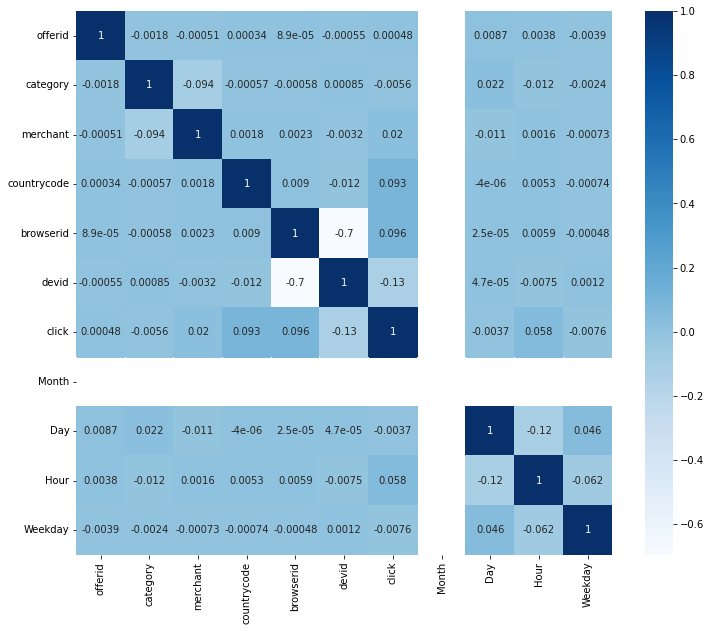

In [ ]:
fig = plt.figure(figsize = (12,10))
sns.heatmap(df2.corr(), cmap='Blues', annot = True) 

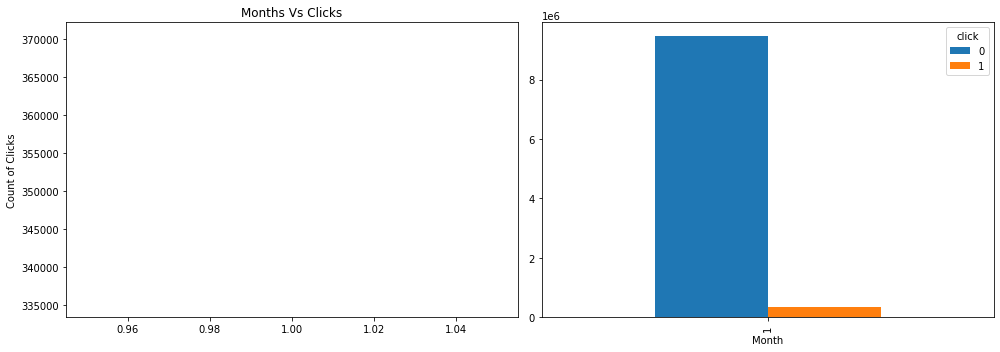

In [ ]:
f,ax=plt.subplots(1,2,figsize=(14,5))
df2['Month'][df2['click']==1].value_counts().sort_index().plot(ax=ax[0])
ax[0].set_title('Months Vs Clicks')
ax[0].set_ylabel('Count of Clicks')
pd.crosstab(df2["click"], df2["Month"]).T.plot(kind = 'bar',ax=ax[1])
#df2.groupby(['Month'])['Clicked on Ad'].sum() # alternative code
plt.tight_layout()
plt.show()

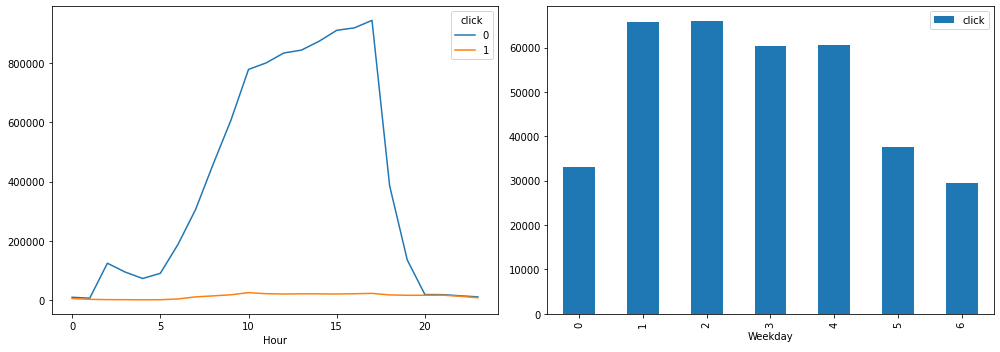

In [ ]:

f,ax=plt.subplots(1,2,figsize=(14,5))
pd.crosstab(df2["click"], df2["Hour"]).T.plot(style = [], ax = ax[0])
pd.pivot_table(df2, index = ['Weekday'], values = ['click'],aggfunc= np.sum).plot(kind = 'bar', ax=ax[1]) # 0 - Monday
plt.tight_layout()
plt.show()


In [ ]:
df2.groupby('click')['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
        'Month', 'Day', 'Hour', 'Weekday'].mean()

,offerid,category,merchant,countrycode,browserid,devid,Month,Day,Hour,Weekday
click,,,,,,,,,,
0,496618.282758,42185.508361,4.889864e+07,1.600080,3.190253,1.070208,1.0,14.914122,12.567130,2.865476
1,497359.068320,41302.233979,5.205643e+07,2.403338,4.557403,0.530633,1.0,14.852214,13.774183,2.794355


In [ ]:
df2.groupby(['devid','click'])['click'].count().unstack()


click,0,1
devid,,
0.0,2551573,183384
1.0,3681369,151557
2.0,3214885,17813


In [ ]:
hdf = pd.pivot_table(df2, index = ['Hour'], columns = ['devid'], values = ['click'], 
                     aggfunc= np.sum).rename(columns = {'click':'Clicked'})

cm = sns.light_palette("green", as_cmap=True)
hdf.style.background_gradient(cmap=cm) #aggregation of clicks per hour as colour gradient

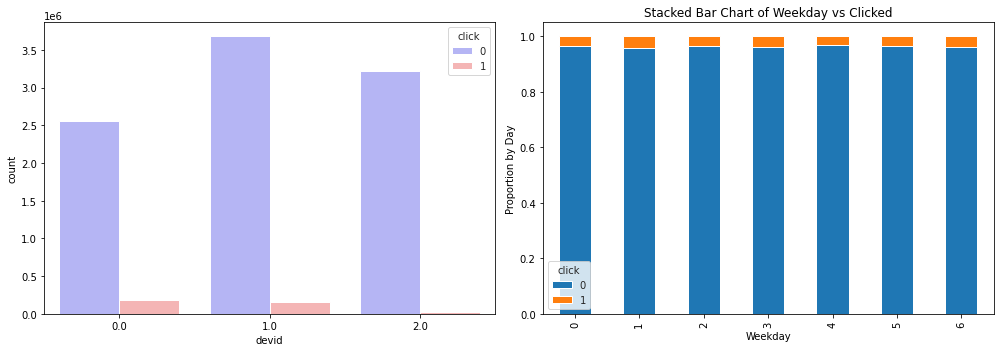

In [ ]:
f,ax=plt.subplots(1,2,figsize=(14,5))
sns.set_style('whitegrid')
sns.countplot(x='devid',hue='click',data=df2,palette='bwr', ax = ax[0]) # Overall distribution of 4G count
table = pd.crosstab(df2['Weekday'],df2['click'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=ax[1], grid = False) # 0 - Monday
ax[1].set_title('Stacked Bar Chart of Weekday vs Clicked')
ax[1].set_ylabel('Proportion by Day')
ax[1].set_xlabel('Weekday')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x)), (x)

def sigmoid_derivative(x, cache):
    activation,_ = sigmoid(cache)
    return x * activation * (1.0 - activation)

def relu(x):
    return np.maximum(0, x), (x)

def relu_derivative(x, cache):
    Z = cache
    dZ = np.array(x, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

#   image shape (length, height, depth)
#   output vec shape (length * height * depth, 1) 
#   len = shape[0], height = shape[1], depth = shape[2] 
#   axis = 1 -> return column vector
#   acis = 0 -> return row vector 
def img2vec(img, row_or_col = 2):
    if row_or_col == 0:
        vec = img.reshape(1, (img.shape[0] * img.shape[1] * img.shape[2]))
    elif row_or_col == 1:
        vec = img.reshape((img.shape[0] * img.shape[1] * img.shape[2]), 1)
    elif row_or_col == 2:
        vec = img.reshape((img.shape[0] * img.shape[1] * img.shape[2]))
    return vec

#def test_img2vec():
#    image = np.array([[[ 0.67826139,  0.29380381],
#            [ 0.90714982,  0.52835647],
#            [ 0.4215251 ,  0.45017551]],
#    
#           [[ 0.92814219,  0.96677647],
#            [ 0.85304703,  0.52351845],
#            [ 0.19981397,  0.27417313]],
#    
#           [[ 0.60659855,  0.00533165],
#            [ 0.10820313,  0.49978937],
#            [ 0.34144279,  0.94630077]]])
#    print ((img2vec(image, 2).shape))
#test_img2vec()

#   norm here computes the Euclidean/Forbenius Norm for every row(vector) in the matrix
#   and then divides the row by the value of the norm
#   axis = 0 -> columns
#   axis = 1 -> rows 
#   keepdims -> never change dimensions of the matrix after the operation 
def normalizeRows(x):
    x_forb_norm = np.linalg.norm(x, ord = None, axis = 1, keepdims = True)
    return x / x_forb_norm

def softmax(x):
    e = np.exp(x)
    return e / np.sum(e, axis = 1, keepdims = True)

def L1_loss(y_hat, y):
    return np.sum(np.abs(y_hat - y))

def L2_loss(y_hat, y):
    return np.sum((y_hat - y)**2)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class LogisticRegression():
    def __init__(self, X, y, learning_rate = 0.5, number_of_iterations = 2000, plot = True):
        self.__W = np.zeros((X.shape[0], 1))
        self.__b = 0.
        self.__X = X
        self.__y = y
        self.__m = X.shape[1]
        self.__learning_rate = learning_rate
        self.__number_of_iterations = number_of_iterations
        self.__grads = {}
        self.__plot = plot
        
    def __activate(self, X):
        activation,_ = sigmoid(np.dot(self.__W.T, X) + self.__b)
        return activation
    
    def __compute_cost(self):
        activation  = self.__activate(self.__X)
        cost = (-1 / self.__m) * (np.sum(self.__y * np.log(activation) + (1 - self.__y) * np.log(1 - activation)))
        cost = np.squeeze(cost)
        return cost
    
    def __propagate(self):
        activation = self.__activate(self.__X)
        dw = (1 / self.__m) * np.dot(self.__X, (activation - self.__y).T)
        db = (1 / self.__m) * np.sum((activation - self.__y))
        return dw, db
    
    def optimize(self):
        grads = {}
        costs = []
        for epoch in range(self.__number_of_iterations + 1):
            dw, db = self.__propagate()
            grads['dw'] = dw
            grads['db'] = db
            self.__W -= self.__learning_rate * dw
            self.__b -= self.__learning_rate * db
            cost = self.__compute_cost()
            if epoch % 100 == 0:
                Y_prediction_train = self.predict(self.__X)
                print('cost at iteration ' + str(epoch) + ' : ' + str(np.round(cost, 4)) + ' accuracy: ' + str(np.round(100 - np.mean(np.abs(Y_prediction_train - self.__y)) * 100, 4)) + '%')
                costs.append(cost)
        if self.__plot == True:
            plt.plot(np.squeeze(costs))
            plt.ylabel('Cost')
            plt.xlabel('Epochs (per tens)')
            plt.title("Learning rate =" + str(self.__learning_rate))
            plt.show()
            Y_prediction_train = self.predict(self.__X)
            print('train accuracy: ' + str(np.round(100 - np.mean(np.abs(Y_prediction_train - self.__y)) * 100, 4)) + '%')
        self.__grads = grads
        return costs
    
    def predict(self, X, y = 'empty'):
        predicted = np.zeros((1, X.shape[1]))
        activation = self.__activate(X)
        for i in range(activation.shape[1]):
            predicted[0, i] = (activation[0, i] > 0.5)
        if y != 'empty':
            self.__confusion_matrix = confusion_matrix(y.T, predicted.T)
        return predicted 
    
    def get_weights(self):
        return self.__W
    
    def get_bias(self):
        return self.__b
    
    def get_confusion_matrix(self):
        return self.__confusion_matrix

In [ ]:
df2.head()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

import numpy as np                    # Linear Algebra

import matplotlib.pyplot as plt       # Visualizations
import seaborn as sns                 # Visualizations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 
import warnings                       # Hide warning messages
warnings.filterwarnings("ignore")
%matplotlib inline      

X = df2.iloc[:, [0, 1, 2,3,4,5,7,8,9,10]].values
Y = df2.iloc[:, 6].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.25, random_state = 0)
# Encoding gender column
labelencoder_X = LabelEncoder()
X_train1[:, 0] = labelencoder_X.fit_transform(X_train1[:, 0])
X_test1[:, 0] = labelencoder_X.fit_transform(X_test1[:, 0])
X_train1 = X_train1.astype(np.float64)
# Scaling features
sc_X = MinMaxScaler()
X_train1 = sc_X.fit_transform(X_train1)
X_test1 = sc_X.transform(X_test1)

In [ ]:
X_train1 = X_train1.T
X_test1 = X_test1.T
Y_train1 = Y_train1.T
Y_test1 = Y_test1.T  

cost at iteration 0 : 0.2802 accuracy: 96.404%
cost at iteration 100 : 0.1495 accuracy: 96.404%
cost at iteration 200 : 0.1464 accuracy: 96.404%
cost at iteration 300 : 0.1449 accuracy: 96.404%


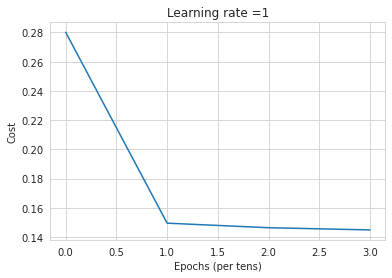

train accuracy: 96.404%
cost at iteration 0 : 0.4356 accuracy: 96.404%
cost at iteration 100 : 0.1526 accuracy: 96.404%
cost at iteration 200 : 0.1496 accuracy: 96.404%
cost at iteration 300 : 0.1477 accuracy: 96.404%


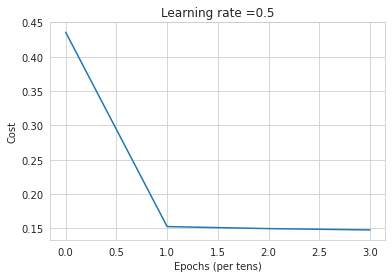

train accuracy: 96.404%
cost at iteration 0 : 0.6623 accuracy: 96.404%
cost at iteration 100 : 0.1806 accuracy: 96.404%
cost at iteration 200 : 0.1614 accuracy: 96.404%
cost at iteration 300 : 0.1573 accuracy: 96.404%


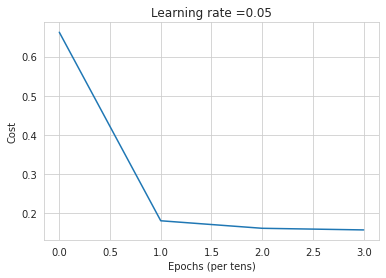

train accuracy: 96.404%
cost at iteration 0 : 0.69 accuracy: 96.404%
cost at iteration 100 : 0.4681 accuracy: 96.404%
cost at iteration 200 : 0.356 accuracy: 96.404%
cost at iteration 300 : 0.2937 accuracy: 96.404%


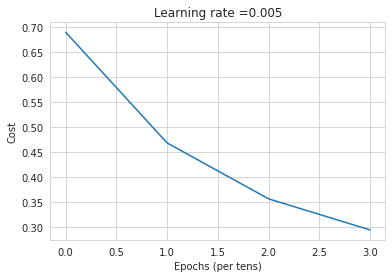

train accuracy: 96.404%


In [ ]:
learning_rates = [1, 0.5, 0.05, 0.005]
costs = []
confusion_matrix_train = []
confusion_matrix_test = []
for i in learning_rates: 
    classifier = LogisticRegression(X_train1, Y_train1, i, 300, True) 
    costs.append((i, classifier.optimize()))
    Y_prediction_train = classifier.predict(X_train1, Y_train1)
    confusion_matrix_train.append(classifier.get_confusion_matrix())
    Y_prediction_test = classifier.predict(X_test1, Y_test1)
    confusion_matrix_test.append(classifier.get_confusion_matrix())

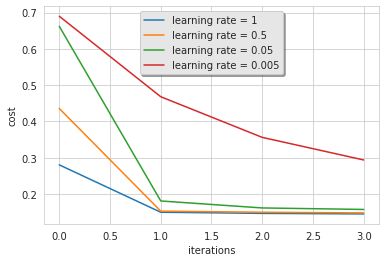

In [ ]:
for i in costs:
    learning_rate, cost = i
    plt.plot(np.squeeze(cost), label= "learning rate = " + str(learning_rate))
plt.ylabel('cost')
plt.xlabel('iterations')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [ ]:
classifier_number = 0
for confusion_mat in confusion_matrix_train:
    #print(confusion_mat[0,0] + " " + confusion_mat[0,1]+confusion_mat[1,0]+confusion_mat[1,1])
    print(confusion_mat[0,0])
    print(confusion_mat[0,1])
    print(confusion_mat[1,0])
    print(confusion_mat[1,1])
    print("##############################")
    classifier_number += 1
    
classifier_number = 0
for confusion_mat in confusion_matrix_train:
    train_accuracy = (confusion_mat[0, 0] + confusion_mat[1, 1]) / np.sum(confusion_mat)
    print("train accuracy on classifier " + str(classifier_number) + ": " + str(np.round(train_accuracy * 100, 4)) + '%')
    classifier_number += 1
classifier_number = 0
for confusion_mat in confusion_matrix_test:
    test_accuracy = (confusion_mat[0, 0] + confusion_mat[1, 1]) / np.sum(confusion_mat)
    
    print("test accuracy on classifier " + str(classifier_number) + ": " + str(np.round(test_accuracy * 100, 4)) + '%')
    classifier_number += 1

7086112
0
264323
0
##############################
7086112
0
264323
0
##############################
7086112
0
264323
0
##############################
7086112
0
264323
0
##############################
train accuracy on classifier 0: 96.404%
train accuracy on classifier 1: 96.404%
train accuracy on classifier 2: 96.404%
train accuracy on classifier 3: 96.404%
test accuracy on classifier 0: 96.3908%
test accuracy on classifier 1: 96.3908%
test accuracy on classifier 2: 96.3908%
test accuracy on classifier 3: 96.3908%


**#################################@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@2**

In [34]:
from sklearn.model_selection import train_test_split
X = df2[['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
        'Month', 'Day', 'Hour', 'Weekday']]
y = df2[['click']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
# We dont have to use stratify method in train_tst_split to handle class distribution as its not imbalanced and does contain equal number of classes i.e 1's and 0's
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6566389, 10) (6566389, 1)
(3234192, 10) (3234192, 1)


**After this is actual classifier with regression as well after is just for testing main chiz ncihe hai**



In [ ]:

from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time

from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

train, test = train_test_split(df2, test_size=.33, random_state=random.seed(2020))


features = list(train.columns.values)
features.remove('click')
print(features)



['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid', 'Month', 'Day', 'Hour', 'Weekday']


In [ ]:

'''
xgboost windows mein nahi chalta linux mac ke liye hai sirf


mein code likh raha hu niche run kar 
'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time

from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt



from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    min_chil_weight=1
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 10
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(X_valid[target].values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(X_valid[target].values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(X_valid[target].values, check2)
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(gbm, features)
    print('Importance array: ', imp)

    print("Predict test set... ")
    test_prediction = gbm.predict(xgb.DMatrix(test[features],missing = -99), ntree_limit=gbm.best_iteration+1)
    score = average_precision_score(test[target].values, test_prediction)

    print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(X_valid[target].values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################


    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return gbm


XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8
[0]	train-logloss:0.620062	eval-logloss:0.603198
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.525213	eval-logloss:0.536209
[2]	train-logloss:0.475882	eval-logloss:0.477223
[3]	train-logloss:0.418867	eval-logloss:0.425988
[4]	train-logloss:0.389176	eval-logloss:0.384182
[5]	train-logloss:0.343347	eval-logloss:0.345841
[6]	train-logloss:0.309942	eval-logloss:0.314178
[7]	train-logloss:0.284463	eval-logloss:0.285379
[8]	train-logloss:0.263095	eval-logloss:0.259088
[9]	train-logloss:0.235829	eval-logloss:0.238911
[10]	train-logloss:0.223039	eval-logloss:0.219604
[11]	train-logloss:0.201861	eval-logloss:0.202734
[12]	train-logloss:0.19167	eval-logloss:0.187349
[13]	train-logloss:0.172167	eval-logloss:0.173913
[14]	train-logloss:0.164557	eval-logloss:0.163098
[15]	train-logloss:0.151621	eval-

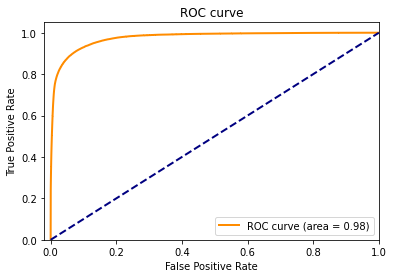

Training time: 50.57 minutes


In [ ]:

xgbm = run_default_test(train,test, features, 'click')
#X_train, X_test, y_train, y_test

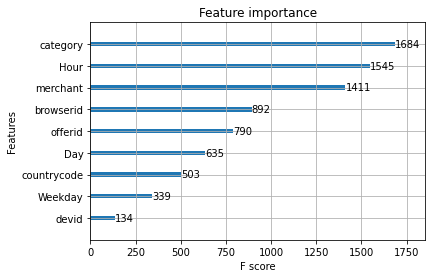

In [ ]:
xgb.plot_importance(xgbm)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

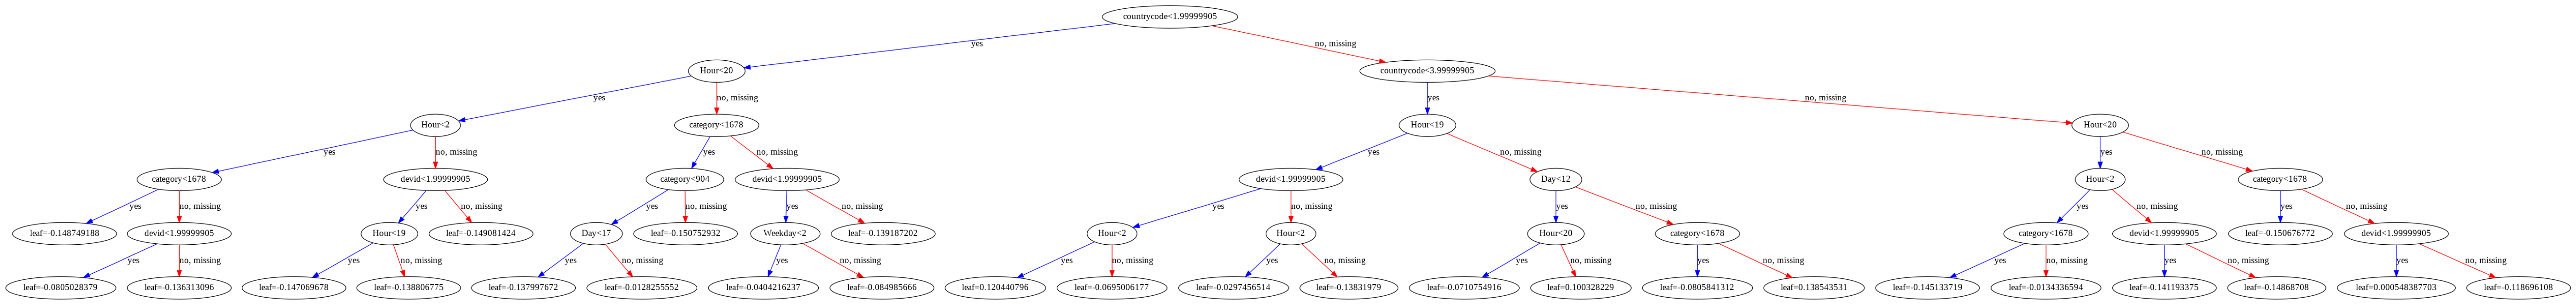

In [ ]:
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(xgbm, num_trees=4, ax=ax)
plt.show()

In [ ]:
#check me apne ko prediction prob mil rahi hai

X_train, X_valid = train_test_split(train, test_size = 0.2, random_state=0)
target = 'click'
y_train = X_train[target]
y_valid = X_valid[target]
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
    
check = xgbm.predict(xgb.DMatrix(X_valid[features]))
print(check[:10])

[0.00155891 0.07892136 0.00038227 0.00930621 0.00049377 0.0010315
 0.04770036 0.00084827 0.0107079  0.00419918]


In [ ]:
from sklearn import metrics
check2 = check.round()
cnf_matrix = metrics.confusion_matrix(y_valid, check2)

Text(0.5, 257.44, 'Predicted label')

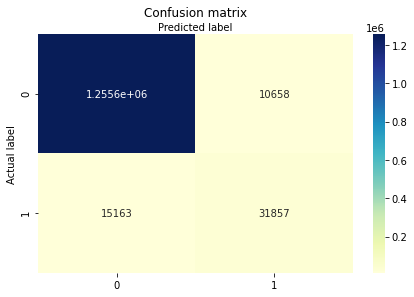

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, check2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1266258
           1       0.75      0.68      0.71     47020

    accuracy                           0.98   1313278
   macro avg       0.87      0.83      0.85   1313278
weighted avg       0.98      0.98      0.98   1313278



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_valid, check2)
print(confusion_matrix)

[[1255600   10658]
 [  15163   31857]]


In [ ]:
print("Hello")

Hello


In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split


train, test = train_test_split(df2, test_size=.33, random_state=0)
X = train[['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
        'Month', 'Day', 'Hour', 'Weekday']]
y = train[['click']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#ceate lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_train[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_train[~msk], reference=lgb_train)

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 16, # defauly leaves(31) amount for each tree
    'learning_rate': 0.5,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.117168
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.161525
[3]	valid_0's binary_logloss: 0.137497
[4]	valid_0's binary_logloss: 0.130815
[5]	valid_0's binary_logloss: 0.082671
[6]	valid_0's binary_logloss: 0.079666
[7]	valid_0's binary_logloss: 0.0843173
[8]	valid_0's binary_logloss: 0.0846427
[9]	valid_0's binary_logloss: 0.0836577
[10]	valid_0's binary_logloss: 0.0838318
[11]	valid_0's binary_logloss: 0.0968498
[12]	valid_0's binary_logloss: 0.0967786
[13]	valid_0's binary_logloss: 0.0946201
[14]	valid_0's binary_logloss: 0.0882339
[15]	valid_0's binary_logloss: 0.089047
[16]	valid_0's binary_logloss: 0.088771
[17]	valid_0's binary_logloss: 0.0871851
[18]	valid_0's binary_logloss: 0.0870091
[19]	valid_0's binary_logloss: 0.0864137
[20]	valid_0's binary_logloss: 0.0859575
[21]	valid_0's binary_logloss: 0.0948383
[22]	valid_0's binary_logloss: 0.0932851
[23]	valid_0's binary_logloss: 0.0

In [ ]:
check = gbm.predict(X_test)
print(check[:10])



[0.00443607 0.00288947 0.00443607 0.024821   0.57934167 0.00443607
 0.00453814 0.00548729 0.00288947 0.024821  ]


In [ ]:
from sklearn import metrics
check2 = check.round()
cnf_matrix = metrics.confusion_matrix(y_test, check2)

Text(0.5, 257.44, 'Predicted label')

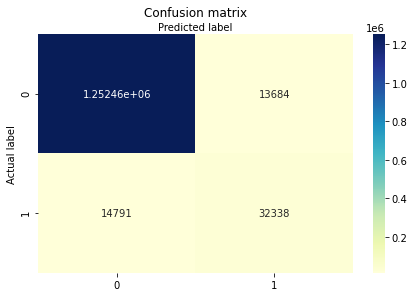

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, check2)
print(confusion_matrix)

[[1252465   13684]
 [  14791   32338]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, check2))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1266149
           1       0.70      0.69      0.69     47129

    accuracy                           0.98   1313278
   macro avg       0.85      0.84      0.84   1313278
weighted avg       0.98      0.98      0.98   1313278



Index(['offerid', 'category', 'merchant', 'countrycode', 'browserid', 'devid',
       'Month', 'Day', 'Hour', 'Weekday'],
      dtype='object')


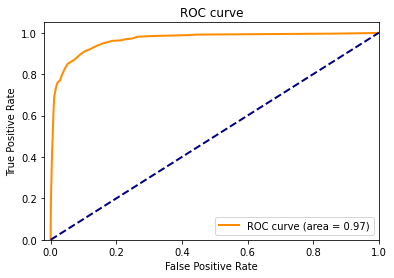

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time

from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
print(X_test.columns)
fpr, tpr, _ = roc_curve(y_test, check)
roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()